#### Example code to calculate quantiles by day of year

In [1]:
import xarray as xr
import numpy as np

In [2]:
awra_dir = '/g/data/fj8/BoM/AWRA/DATA/SCHEDULED-V6/processed/values/day/'
sm_files = 'sm_pct_[1-2]*.nc'

# soil moisture data as degree of saturation; read in the data
ds_sm_temp = xr.open_mfdataset(awra_dir + sm_files)

time_slice = slice('1981-01-01', '2021-12-31')
lat_sel = -37
lon_sel = 148

# get data at a grid point
da_sm = ds_sm_temp.sel(latitude = lat_sel, longitude = lon_sel, time = time_slice)
da_sm = da_sm.load()

# create empty lists to save the calculated quantiles
list_doy = []
list_da_quant = []

# create a new dimension named window. "window" contains 13 days: 6 days before, 6 days after & the day
# use data from "window" to calculate percentile for each day of the year (doy)
for doy, sample in da_sm.rolling(time=13, center=True).construct(time='window').groupby('time.dayofyear'):
    da_quant_bydoy = sample.load().quantile([0.1, 0.3], dim=['time', 'window'])
    list_doy.append(doy)
    list_da_quant.append(da_quant_bydoy)

In [3]:
# list_da_quant contains 366 elements - one for each day of year
# concatenate the data to create a dimension named dayofyear - this takes a few minutes to run
ds_sm_pct_perc = xr.concat(list_da_quant, dim = 'dayofyear').assign_coords({'dayofyear': list_doy})
ds_sm_pct_perc

<xarray.Dataset>
Dimensions:    (dayofyear: 366, quantile: 2)
Coordinates:
  * quantile   (quantile) float64 0.1 0.3
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    sm_pct     (dayofyear, quantile) float64 0.3572 0.4912 ... 0.4161 0.4995

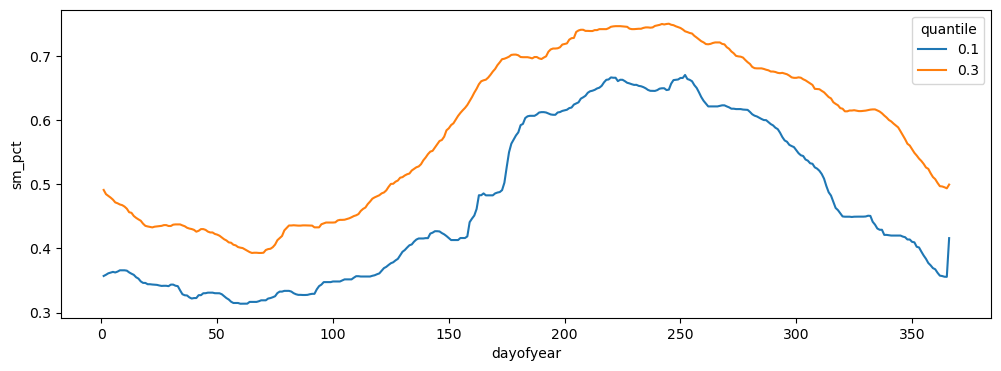

In [5]:
# quick plot of the calculated quantiles
ds_sm_pct_perc['sm_pct'].plot(size = 4, aspect = 3, hue = 'quantile')

In [6]:
# save the calculated data to a netcdf file for future use

out_dir = '/g/data/w97/ad9701/'
out_file = 'example_awra_sm_pct_quantiles.nc'
ds_sm_pct_perc.to_netcdf(out_dir + out_file)